Here I made an RL algorithm learn pacman - I added some code to improve exploration (bonus points?) and tuned the parameters but left the rest the same. I've got to say that this exercise was _much_ harder than the other two as pacman takes ages to die and therefore the algorithm takes almost a whole day to train. That means I only had about 6 tries to tune the params.

In [0]:
#!pip install gym

# GYM provides an environment for an agent to interact with. We'll look at the 'cartpole',
#  or the unstable, top-heavy inverted pendulum on top of a cart, which our 'agent' must learn to balance.
#
# GYM provides:
#  - a state (observation) of the system/environment
#    (in case of cartpole: cart position and velocity, angle and velocity at the tip
#  - a set of _actions_ the agent can undertake in the environment
#    (in case of cartpole: moving the cart base left or right)

# When an agent performs a certain action in the current enviroment, GYM returns
#  - a _reward_ for a certain result of performing the action in the environment
#    (in case of cartpole: +1 if it didn't die.)
#  - the new _state_ of the environment after performing said action
#    (in case of cartpole: the effect of gravity pulling on the pendulum's top, on the angle, in one time step)
#  - a 'terminal' in case the state is such that the agent cannot continue (is 'dead')
#    (in case of cartpole: if the angle exceeds > 5 degrees of tipping over, or it flies off-screen)

# It is up to us to make an agent that learns which action to take in which state, to maximise the total reward before it dies.
#  We do this by 'remembering' what the results were of certain actions on certain states in a memory (i.e. a list or deque),
#  And after every 'death' we sample ('replay') from this memory to train a neural network that decides the best actions
#   we can take on any state we've encountered so far, which maximises the total reward.

# In addition, GYM provides a nice real-time visual output of the environment and the result of actions taken.
#  In google COLAB however, we pull some strings, and only have a combined video at the end.


In [0]:
COLAB = True

if(COLAB) :
  # install some helpers to visualize gym graphics in the colab environment
  !pip install gym pyvirtualdisplay > /dev/null 2>&1
  !apt-get install -y xvfb python-opengl ffmpeg x11-utils > /dev/null 2>&1

In [2]:
import gym
import numpy as np
from matplotlib import pyplot as plt
import random

from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
# only necessary for visualisation in colab env.
if(COLAB) :
  from IPython.display import HTML
  from IPython import display as ipythondisplay
  from pyvirtualdisplay import Display
  from gym.wrappers import Monitor
  import glob, io, os, base64
  from moviepy.editor import VideoFileClip, concatenate_videoclips

  display = Display(visible=0, size=(1400, 900))
  display.start()
  os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

  def combine_videos() :
    mp4list = sorted( glob.glob('video/*.mp4') )
    if len(mp4list) > 0 :
      videolist = []
      for mp4 in mp4list :
        videolist.append( VideoFileClip(mp4))
      final_clip = concatenate_videoclips(videolist)
      final_clip.to_videofile("combined.mp4", fps=24, remove_temp=False)
      return 1
    else :
      return 0

  def show_video() :
      if(combine_videos()) :
        video = io.open("combined.mp4", 'r+b').read()

        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                  loop controls style="height: 400px;">
                  <source src="data:video/mp4;base64,{0}" type="video/mp4" />
               </video>'''.format(encoded.decode('ascii'))))
      else :
        print("Error: no videos found")     


  def wrap_env(env):
    env = Monitor(env, './video', video_callable=lambda episode_id: True, force=True)
    return env


Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1875968/45929032 bytes (4.1%)5947392/45929032 bytes (12.9%)9994240/45929032 bytes (21.8%)14057472/45929032 bytes (30.6%)17956864/45929032 bytes (39.1%)22093824/45929032 bytes (48.1%)26296320/45929032 bytes (57.3%)30482432/45929032 bytes (66.4%)34668544/45929032 bytes (75.5%)38764544/45929032 bytes (84.4%)42983424/45929032 bytes (93.6%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root/.

In [0]:
ENV_NAME = "MsPacman-ram-v0"


# those params work well but you need a solid day or so to train the 
# model - I can't attach the output as it's too big

MAXRUNS = 100
#NSTEPSOLVED = 1000

GAMMA = 0.1  # 'future discount factor'
LEARNING_RATE = 0.01 # rate at which to update weights after each training step

MEMORY_SIZE = 10000 # size of container to hold actions and outcomes
BATCH_SIZE = 50 # number of actions in memory to 'replay' after each death

# probability to do 'random' actions, to sample from event space
EXPLORATION_MAX = 1.0  
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.998   


In [0]:
import tensorflow as tf
import keras
INPUT_NODES = 128 
OUTPUT_NODES = 9
class DQNSolver:

    def __init__(self, observation_space, action_space):
        self.exploration_rate = EXPLORATION_MAX

        self.action_space = action_space
        self.memory = deque(maxlen=MEMORY_SIZE)

        # This will be a simple feed-forward NN, with 
        #  - input = 'observation' (aka state)
        #  - output = predicted 'quality' of each possible actio
        self.model = keras.Sequential([
        keras.layers.Dense(input_shape=(INPUT_NODES,), units=2),
        keras.layers.Dense(128, activation=tf.nn.relu),
        keras.layers.Dense(OUTPUT_NODES, activation=tf.nn.softmax)
        ])


        self.model.compile(loss="mse", optimizer=Adam(lr=LEARNING_RATE))
        self.model.summary()
        
    def remember(self, state, action, reward, next_state, done):
        # add event to memory
        self.memory.append((state, action, reward, next_state, done))

    '''Changed this method to not only return the best value but all - important later'''
    def act(self, state):
        # return the outputs for each action from the neural net
        # sometimes allow for a random action at the 'exploration rate', to avoid local minima
        q_values = self.model.predict(state) 
        if np.random.rand() < self.exploration_rate:
            a = np.random.rand(10)
            a = np.array(a/np.sum(a))
            return a
        return q_values

    def experience_replay(self):
        # Learn from random subset of memory (reduces corr. between subsequent actions).
        # learning is done by comparing 'predicted quality' to the here defined quality (~reward) of the action.
        
        if len(self.memory) < BATCH_SIZE:
            # We haven't experienced enough to properly learn yet - keep exploring!
            return
        
        # Get random subset of memory
        batch = random.sample(self.memory, BATCH_SIZE) 
        
        for state, action, reward, state_next, terminal in batch:

            # We define the 'quality' of a move by taking the known, memorized reward for the action,
            #  and adding the predicted quality of the (predicted) best choice of action for the next state, to that.
            # As the model learns to give this situation a low quality, any step leading up to this state will get a 
            #  lower quality due to the predict(state_next) term. This will slowly trickle through to the step before that, etc.,
            #  slowly making our agent learn about future consequences of current actions.
          
            q_update = reward
            if not terminal:
                q_update = (reward + GAMMA * np.amax(self.model.predict(state_next)[0]))
                
                # One could try to make the model learn from intermediate steps directly as well, speeding up the learning,
                #  e.g. by changing the reward based on an increase in angle (although this should really be defined in the env.)
                #q_update -= 1.0 * abs(state_next[0][2]) - abs(state[0][2]) # penalize angle increases for cartpole
                
            # - Define the quality of the non-chosen action to just be the predicted quality (i.e. diff = 0)
            # - Define the quality of the chosen action to be the newly defined quality
            q_values = self.model.predict(state)
            q_values[0][action] = q_update 
            
            # Finally, find the optimal model weights for minimal difference between 
            #  predicted quality and observed quality (+ future prediction as per above) for this action.
            # The weights are then updated * learning rate
            self.model.fit(state, q_values, verbose=0) 
            
        # reduce the 'random choices' rate over time, because you expect the model to have learned
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

In [0]:
action = 0
def pacman() :
    if(COLAB) : env = wrap_env(gym.make(ENV_NAME)) # only for visualisation in colab
    else : env = gym.make(ENV_NAME)

    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    dqn_solver = DQNSolver(observation_space, action_space)
       
    run=0
    runsteplog = []
    #while True:
    for i in range(MAXRUNS):
        run += 1
        state = env.reset()
        state = np.reshape(state, [1, observation_space])
        step = 0
        
        while True :    
            step += 1
            screen = env.render() # graphical output


            
            # this looks at the outputs of the neural net and makes each action
            # with the chance that the corresponding node outputs
            r = np.random.rand()
            actions = dqn_solver.act(state)
            for i in range(len(actions)-1):
              actions[i+1] = actions[i]+actions[i+1]
              if actions[i]>=r:
                action = i
                break
           
            # make the action
            state_next, reward, terminal, info = env.step(action) 

            # if action made terminal: reduce reward!
            reward = reward if not terminal else -reward  

            state_next = np.reshape(state_next, [1, observation_space])

            # fill agent memory with this action's results
            dqn_solver.remember(state, action, reward, state_next, terminal) 

            # prepare for the next action in the environment
            state = state_next 
            
            if terminal :
                #state = env.reset()
                #state = np.reshape(state, [1, observation_space])
                print("Run: {0}, exploration: {1:.15f}, score: {2}".format(run,dqn_solver.exploration_rate,step)) 
                runsteplog += [step]

                break
            
            dqn_solver.experience_replay() # learn from batch of memories every time a new one is made
            
            #if(step > NSTEPSOLVED) :
            #    i = MAXRUNS
            #    print("Solved! (step > NSTEPSOLVED)")
            #    break


    env.close()
    


    # Show training process
    
    # plot #steps achieved
    plt.plot(runsteplog)
    plt.ylabel("# actions before terminal")
    plt.xlabel("run iteration")

    success_measure = np.mean(runsteplog[-15:])
    print("Mean of last 15 runs: {0}".format(success_measure))
    return success_measure

Set MAXRUNS back to 50 to train properly - to have a runnable version I reduced it to two just to show that the code runs

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 2)                 258       
_________________________________________________________________
dense_8 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_9 (Dense)              (None, 9)                 1161      
Total params: 1,803
Trainable params: 1,803
Non-trainable params: 0
_________________________________________________________________








Run: 1, exploration: 0.300832513575459, score: 650
Run: 2, exploration: 0.064522475652389, score: 770
Mean of last 15 runs: 710.0
[MoviePy] >>>> Building video combined.mp4
[MoviePy] Writing video combined.mp4


100%|██████████| 1138/1138 [00:01<00:00, 710.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: combined.mp4 



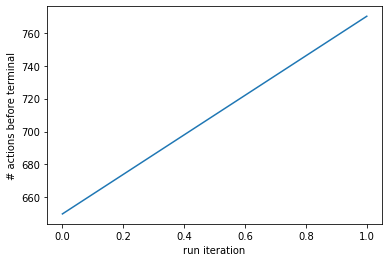

In [10]:
MAXRUNS = 2

if __name__ == "__main__":
    pacman()

if(COLAB) :
    show_video() 

In [0]:
COLAB
if(COLAB) : env = wrap_env(gym.make(ENV_NAME)) # only for visualisation in colab
else : env = gym.make(ENV_NAME)
print(env.action_space)
print(env.action_space)

In [0]:
a = np.random.rand()
print(a)

0.9095402627721901
